<a name="intro"></a>

# Notebook 3: Análisis del Modelo de Vecinos Más Cercanos (KNN)

## Introducción

Este notebook está dedicado al modelo de Vecinos Más Cercanos (KNN) que opera bajo el principio de que cosas similares existen en proximidad cercana. En el contexto de nuestro conjunto de datos de la bomba de agua, utilizaremos KNN para predecir el rendimiento de la bomba basándonos en la similitud de las condiciones de operación con instancias conocidas.

Después de cargar el conjunto de datos, seleccionaremos un valor apropiado para 'k' (el número de vecinos) e implementaremos el modelo KNN. Luego evaluaremos el rendimiento del modelo y los valores SHAP para comparar su efectividad con los otros modelos explorados en esta serie de notebooks.

<a name="indice"></a>
# Índice

*   [Introducción](#intro)

*   [Librerias](#librerias)

*   [Preparación de los datos](#readingdata)

  - [Carga del conjunto de datos](#cargardatos)
  - [Conjuntos de entrenamiento y prueba](#limpiardatos)  

*   [Modelo de KNN](#modeloredes)

  - [Definición del modelo](#definicionmodelos)
  - [Entrenamiento del modelo](#entrenamientomodelos)
  - [Evaluación del modelo](#evaluacionmodelos)
  - [Importancia de las variables (SHAP)](#importanciavariables)

*   [Guardando los resultados](#guardar)

<a name="librerias"></a>

## Librerias

[Keras](https://es.wikipedia.org/wiki/Keras) es una API de redes neuronales de alto nivel que puede ejecutarse sobre [Tensorflow](https://es.wikipedia.org/wiki/TensorFlow), lo que permite el prototipado fácil y rápido de modelos de aprendizaje profundo. TensorFlow, desarrollado por el equipo de Google Brain, es una plataforma de código abierto de extremo a extremo para el aprendizaje automático que proporciona un ecosistema integral de herramientas y bibliotecas para construir y desplegar aplicaciones impulsadas por el aprendizaje automático.

[Numpy](https://es.wikipedia.org/wiki/NumPy) es un paquete fundamental para la computación científica en Python, que proporciona soporte para matrices y arreglos multidimensionales de gran tamaño, junto con una colección de funciones matemáticas para operar eficientemente en estos arreglos.

[Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) es una biblioteca que ofrece estructuras de datos y herramientas de análisis de datos de alto rendimiento y fáciles de usar para Python. Su estructura de datos principal es el DataFrame, que permite almacenar y manipular datos tabulares en filas de observaciones y columnas de variables.

[Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) es una biblioteca de trazado de gráficos para Python y su extensión matemática numérica, NumPy. Proporciona una API orientada a objetos para incrustar gráficos en aplicaciones utilizando herramientas de interfaz gráfica de usuario de propósito general como Tkinter, wxPython, Qt o GTK.

El módulo "random" implementa generadores de números pseudoaleatorios para diversas distribuciones y es útil para tareas como la selección aleatoria de muestras y la elección de elementos aleatorios de un rango o colección.

[Scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn) (Sklearn) es una biblioteca de aprendizaje automático para Python que proporciona herramientas simples y eficientes para la minería de datos y el análisis de datos. Cuenta con varios algoritmos de clasificación, regresión y agrupamiento.

[SHAP](https://shap.readthedocs.io/en/latest/index.html) (SHapley Additive exPlanations) es una biblioteca que explica la salida de los modelos de aprendizaje automático mediante el cálculo de la contribución de cada característica a la predicción.

Google Colab es un servicio en la nube gratuito basado en Jupyter Notebooks que admite GPU gratuitas e integra con Google Drive. Se utiliza para la educación e investigación en aprendizaje automático, proporcionando un entorno fácil de usar para escribir y ejecutar código Python, lo cual es especialmente beneficioso para proyectos colaborativos.

In [ ]:
# Librerias generales
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para trabajar con números aleatorios
import random

# Otras librerias auxiliares de scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Librearias para el KNN
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump

# Librería SHAP
!pip install shap # Esta librería no está instalada por defecto en Google,
                  # con este código se instala en la sesión
import shap

# Libreria para el uso de archivos
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.3 MB/s eta 0:00:00


[(*volver al índice*)](#indice)

<a name="readingdata"></a>
# Preparado de datos

<a name="cargardatos"></a>
## Cargar el conjunto de datos

Cargamos los datos en memoria y comprobamos que todo funciona. Los datos ya están balanceados por el código anterior disponible en el Notebook 0.

La primera vez que te conectas el drive de Google te pide permiso para acceder y tienes que pinchar en aceptar dicho permiso.

In [ ]:
# Nombre del archivos con las X e Ys
X_FILE_NAME = "Datos_balanceados_X_6000.txt"
Y_FILE_NAME = "Datos_balanceados_Y_6000.txt"

# Nombre de los directorios con los ficheros
PROJECT_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
DATA_FOLDER    = "/Resultados/Balanceo de datos/"

# Montar el disco de drive
drive.mount('/content/drive')

# Guardamos el ID de cada sensor; notice that ID 15 is not in the list
sensorNames = ["SENSOR_00", "SENSOR_01", "SENSOR_02", "SENSOR_03", "SENSOR_04",
               "SENSOR_05", "SENSOR_06", "SENSOR_07", "SENSOR_08", "SENSOR_09",
               "SENSOR_10", "SENSOR_11", "SENSOR_12", "SENSOR_13", "SENSOR_14",
               "SENSOR_16", "SENSOR_17", "SENSOR_18", "SENSOR_19", "SENSOR_20",
               "SENSOR_21", "SENSOR_22", "SENSOR_23", "SENSOR_24", "SENSOR_25",
               "SENSOR_26", "SENSOR_27", "SENSOR_28", "SENSOR_29", "SENSOR_30",
               "SENSOR_31", "SENSOR_32", "SENSOR_33", "SENSOR_34", "SENSOR_35",
               "SENSOR_36", "SENSOR_37", "SENSOR_38", "SENSOR_39", "SENSOR_40",
               "SENSOR_41", "SENSOR_42", "SENSOR_43", "SENSOR_44", "SENSOR_45",
               "SENSOR_46", "SENSOR_47", "SENSOR_48", "SENSOR_49", "SENSOR_50",
               "SENSOR_51"]

# Guardamos el significado de cada sensor
sensorProperties = ["Motor Casing Vibration", "Motor Frequency A",
                    "Motor Frequency B", "Motor Frequency C", "Motor Speed",
                    "Motor Current", "Motor Active Power",
                    "Motor Apparent Power", "Motor Reactive Power",
                    "Motor Shaft Power", "Motor Phase Current A",
                    "Motor Phase Current B", "Motor Phase Current C",
                    "Motor Coupling Vibration", "Motor Phase Voltage AB",
                    "Motor Phase Voltage BC", "Motor Phase Voltage CA",
                    "Pump Casing Vibration", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Inlet Flow", "Pump Discharge Flow", "Pump UNKNOWN",
                    "Pump Lube Oil Overhead Reservoir Level",
                    "Pump Lube Oil Return Temp", "Pump Lube Oil Supply Temp",
                    "Pump Thrust Bearing Active Temp",
                    "Motor Non Drive End Radial Bearing Temp 1",
                    "Motor Non Drive End Radial Bearing Temp 2",
                    "Pump Thrust Bearing Inactive Temp",
                    "Pump Drive End Radial Bearing Temp 1",
                    "Pump non Drive End Radial Bearing Temp 1",
                    "Pump Non Drive End Radial Bearing Temp 2",
                    "Pump Drive End Radial Bearing Temp 2",
                    "Pump Inlet Pressure", "Pump Temp Unknown",
                    "Pump Discharge Pressure 1", "Pump Discharge Pressure 2"]

# Recordamos que eliminamos los datos de los sensores 15 y 50. Así que
# procedemos a eliminar también los nombres de estas listas
#
# Pero el sensor 15, NO ESTÁ EN LA LISTA.
# Sólo quitamos el 50, que corresponde con la posición 49 (vaya lío)
del sensorProperties[49]
del sensorNames[49]

# Cárgamos el archivo en un dataframe
# NOTA: La columna para el sensor 15 está vacía, esto es correcto
data_x = pd.read_csv( PROJECT_FOLDER + DATA_FOLDER + X_FILE_NAME, sep = " ", header=None)
data_y = pd.read_csv( PROJECT_FOLDER + DATA_FOLDER + Y_FILE_NAME, sep = " ", header=None)
data_y = data_y.astype(int)

# Renombramos los nombres de las columnas para mayor claridad
data_x.columns = sensorNames
data_y.columns = ["Y"]

print("Cargado de datos concluido")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargado de datos concluido


<a name="limpiardatos"></a>
## Conjunto de entramiento y test de datos

Dividimos el conjunto de los 6000 datos en entrenamiento y test con una proporción del 80%, de tal forma que el conjunto de entrenamiento tendrá unos 4800 datos y el de test alrededor de 1200.

In [ ]:
# Semilla aleatoria constante para reproducibilidad
RANDOM_SEED = 42

# Declaramos la proporción de datos que son para entrenar y para testear
TRAIN_PROPORTION = 0.8 # Esto significa el 80% de los datos para el conjunto
                       # de entrenamiento y el 20% para el conjunto test

# Separamos los datos en conjunto de entrenamiento y datos:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_x, data_y, test_size = (1 - TRAIN_PROPORTION), random_state = RANDOM_SEED)

# Los convertimos de vuelta a dataframes
Xtrain = pd.DataFrame(Xtrain, columns=data_x.columns)
Xtest  = pd.DataFrame(Xtest,  columns=data_x.columns)
Ytrain = pd.DataFrame(Ytrain, columns=data_y.columns)
Ytest  = pd.DataFrame(Ytest,  columns=data_y.columns)

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = Xtrain.shape[0]
totalInputsColumns = Xtrain.shape[1]

[(*volver al índice*)](#indice)

<a name="#modeloredes"></a>
# KNN (K-Nearest Neighbors)

El algoritmo de kNN es un clasificador que funciona tanto para variables discretas como variables continuas.

Vídeo de introducción https://www.youtube.com/watch?v=48RqX4HTtCE

La ventaja sobre las redes neuronales es que, en comparación, el entrenamiento del modelo es casi inmediato. En contraposición, no sirve para modelos mucho más complejos como pudiera ser redes convulucionales para generación de imágenes o modelos de lenguaje, entre otros. También es difícil poder estimar la importancia de cada variable en el modelo; para ello es mejor usar un Random Forest or regresión Lasso.

No confundir kNN con el algoritmo K-means, que se usa para el clustering de datos.

Primero vamos a encontrar primero cual es el K óptimo para nuestro problema. En el caso del algoritmo KNN, K controla la cantidad de vecindarios utilizados para modelar las propiedades estadísticas locales. Un valor muy pequeño para K hace que el modelo sea más sensible a excepciones locales, otorgando demasiado peso a estos puntos particulares (sobreajuste, overfitting). Un valor demasiado grande de K haría que el modelo ignorase la estructura local de la distribución que se intenta aprender (insuficiencia de ajuste, underfitting)

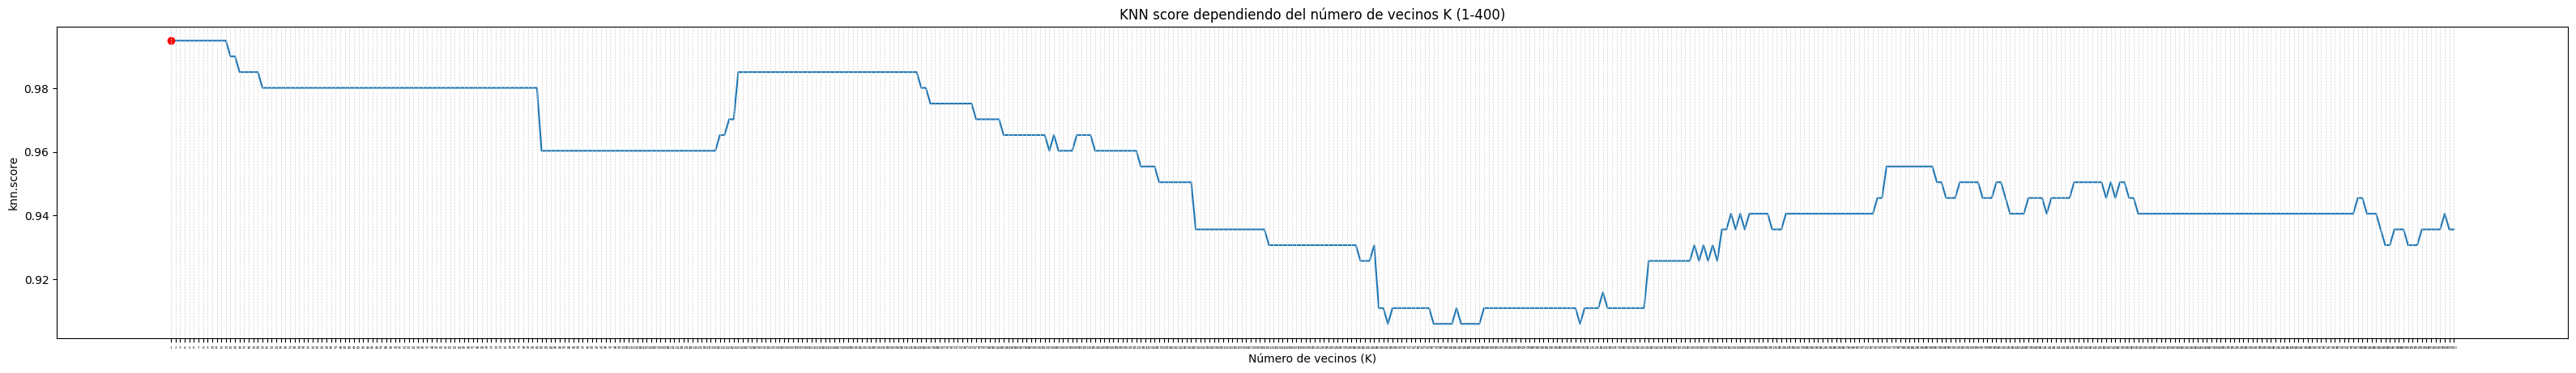

In [ ]:
K_NUMBERS = 500

# Inicializar el vector donde pondremos los datos
knn_data = np.random.rand(K_NUMBERS)

# Rellenar el vector variando el número de Ks
for x in range(K_NUMBERS):
  knn = KNeighborsClassifier(n_neighbors = x+1)
  knn.fit(Xtrain, Ytrain.squeeze())
  current_score = knn.score(Xtest,Ytest.squeeze())
  knn_data[x-1] = current_score

# /!\ El último número, sea cual sea el rando de K_NUMBERS, siempre falla y da
# resultados muy altos. No tengo ni idea de porqué no se mantiene, así que lo
# hago de nuevo aquí aparte:
knn = KNeighborsClassifier(n_neighbors = K_NUMBERS)
knn.fit(Xtrain, Ytrain.squeeze())
current_score = knn.score(Xtest,Ytest.squeeze())
knn_data[K_NUMBERS-1] = current_score

# Creamos un vector para el eje X
x_axis = np.arange(1, K_NUMBERS+1)

# Definimos el tamaño de la figura
figure_size = (40, 5)
plt.figure(figsize=figure_size)

# Creamos una figura que será una línea continua
plt.plot(x_axis, knn_data)

# Encontramos el valor máximo y lo marcamos con un punto rojo
max_y_index = np.argmax(knn_data)
plt.plot(x_axis[max_y_index], knn_data[max_y_index], 'ro')

# Ponemos el título y etiquetas de los ejes
plt.title('KNN score dependiendo del número de vecinos K (1-400)')
plt.xlabel('Número de vecinos (K)')
plt.ylabel('knn.score')

# Hacemos que el eje X muestre todos los números, y solo números enteros
plt.xticks(x_axis)

# Disminuimos un poco el tamaño de letra del eje X
plt.xticks(x_axis, fontsize = 3)

# Añadimos líneas verticales para mejor visualización
for x in x_axis:
    plt.axvline(x=x, color='lightgrey', linestyle='--', linewidth=0.5)

# Mostrar el gráfico
plt.show()


El K óptimo está en K=1 porque con K = 1 el algoritmo de KNN tiende al overfitting. El K-Score tiende a disminuir cuando K es más grande. Así que vamos a poner K = 4, lo cual tiene más sentido dado que es el número de variables que recomendaba el screeplot del PLS.



In [ ]:
# Creamos el modelo KNN
knn = KNeighborsClassifier(n_neighbors = 4)

# Ajustar el modelo
knn.fit(Xtrain, Ytrain.squeeze())

print(knn.score(Xtest,Ytest.squeeze()))

0.9950779327317474


<a name="importanciavariables"></a>
## Importancia de cada variable.

A partir de aquí el código es muy parecido al notebook 1 de las ANN, pero usando el explainer para KNN en su lugar.

In [ ]:
# Declaramos la paciencia que vamos a tener con respesto al cálculo del SHAP.
#
# - 10 tarda unos pocos segundos y se debe usar para comprobaciones del código.
#
# - 200 es un tamaño de muestra decente, pero tarda unas 2 horas. Este es el
#   valor que se usa para la versión final de todos los gráficos y resultados.
TOTAL_SHAP_TESTS = 200

# Transforma los datos de dataframe a matriz para poder usarlos en las
# siguientes funciones
XtestNumpy  = Xtest.to_numpy()

# Usar este algorithmo con muchas muestras tarda mucho tiempo
# Aquí pruebo a reducirlo un poco para probar los resultados iniciales

# ---- Primero, decir cuantas veces se van a ejecutar el test. En este caso 200.
mySamplesKNN   = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)

# ---- Se hacen las predicciones.
explainerKNN    = shap.KernelExplainer(knn.predict,mySamplesKNN)
shap_valuesKNN2 = explainerKNN(mySamplesKNN)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Creamos varios vectores donde almacenamos los valores SHAP, esto sirve para
# poder guardar luego los resultados y no tener que esperar otras 2h si queremos
# generar gráficos relacionados con los valores SHAP.

vectorSHAP_valores = shap_valuesKNN2.values
vectorSHAP_base    = shap_valuesKNN2.base_values
vectorSHAP_data    = shap_valuesKNN2.data

# Guardamos también varios valores de medias y desviaciones típicas que usaremos
# en el mapa de calor final.

vectorMedias    = np.mean(shap_valuesKNN2.values,              axis=0)
vectorAbsMedias = np.mean(np.absolute(shap_valuesKNN2.values), axis=0)
vectorSigmas    = np.std( shap_valuesKNN2.values,              axis=0)
vectorAbsSigmas = np.std( np.absolute(shap_valuesKNN2.values), axis=0)

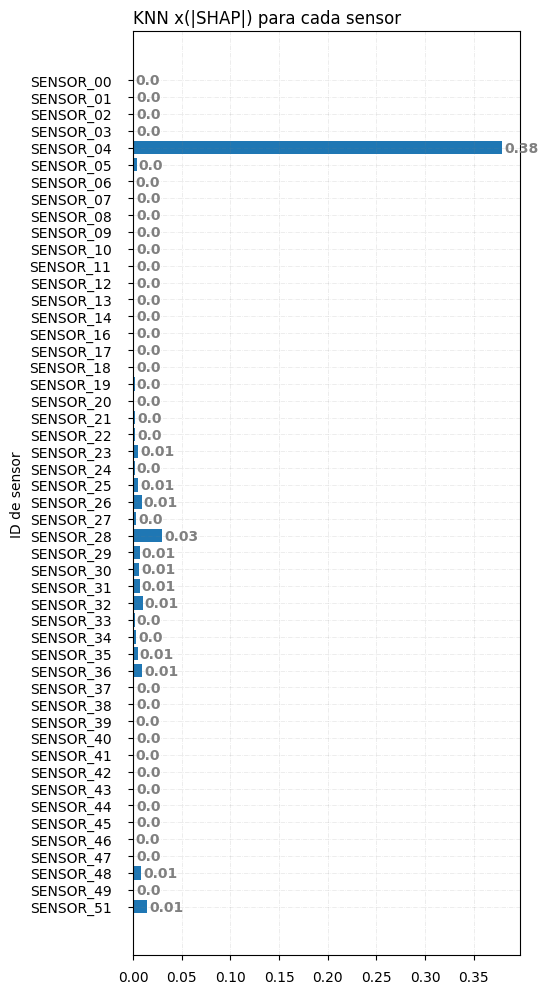

In [ ]:
# Mostrar el gráfico

# Este comando es lo mismo, pero sólo muestra los 20 primeros, para mantener consistencia muestro los 50 sensores.
# shap.summary_plot( shap_values , mySamples, feature_names = list(Xtrain.columns) )

variablesNames = list(sensorNames)
currentPlotTitle = 'KNN x(|SHAP|) para cada sensor'

# Create the plot dataframe
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) , columns = ['name', 'value'] )
barplotData.iloc[:,0] = variablesNames
barplotData.iloc[:,1] = vectorAbsMedias

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(barplotData.iloc[:,0],  barplotData.iloc[:,1])


# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=7)
ax.yaxis.set_tick_params(pad=12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

  currentOffset = 0.002
  currentW = i.get_width()
  if(currentW < 0): currentOffset = -0.005

  plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
           str(round((i.get_width()), 2)),
           fontsize=10, fontweight='bold',
           color='grey')


# Add Plot Title
ax.set_title(currentPlotTitle,loc='left', )
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

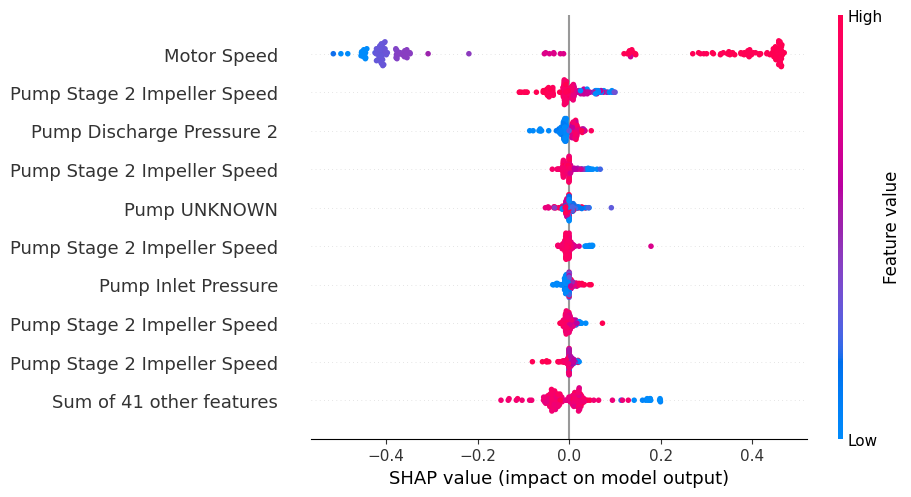

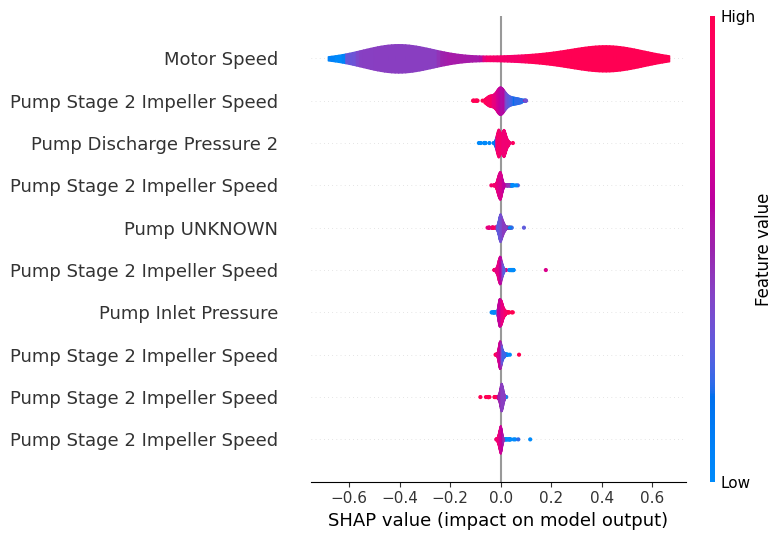

In [ ]:
# Para poder hacer el beeswarm hay que hacer unas transformaciones un poco raras
# primero. Aquí simplemente convierto un objecto explanation del SHAP a otro
# objeto.
explanation3 = shap.Explanation(
    values        = vectorSHAP_valores.squeeze(),
    base_values   = vectorSHAP_base,
    data          = vectorSHAP_data,
    feature_names = sensorProperties
)

# Plots del beeswarm y violin
shap.plots.beeswarm(explanation3)
shap.summary_plot(explanation3, plot_type='violin', max_display=10)

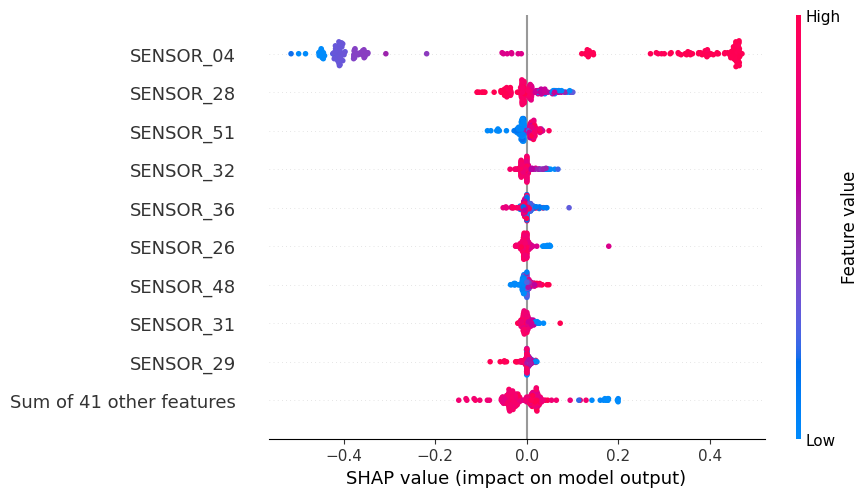

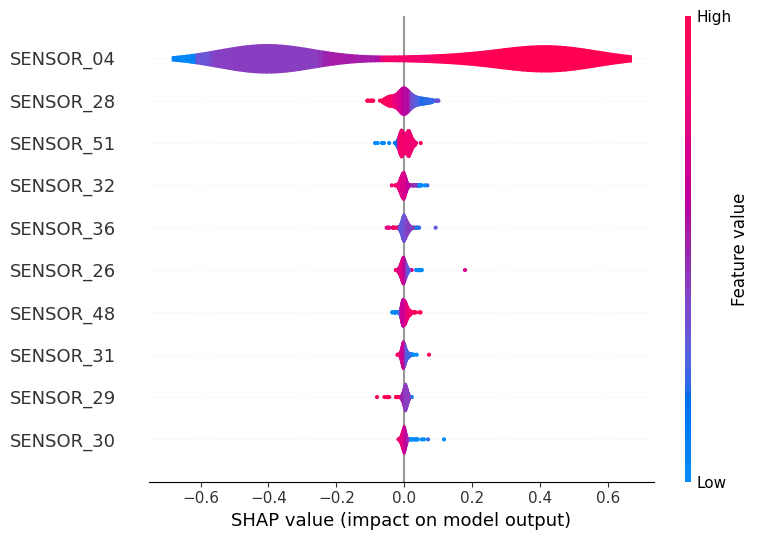

In [ ]:
# Mismo gráfico con ID de sensor en lugar de función
explanation3 = shap.Explanation(
    values        = vectorSHAP_valores.squeeze(),
    base_values   = vectorSHAP_base,
    data          = vectorSHAP_data,
    feature_names = sensorNames
)

# Plots del beeswarm y violin
shap.plots.beeswarm(explanation3)
shap.summary_plot(explanation3, plot_type='violin', max_display=10)

<a name="guardar"></a>

## Guardado de resultados

En esta sección guardamos todos los resultados y logs en la carpeta de Resultados/ANN del drive.

In [ ]:
# ------------------------------------------------------------------------------
# Valores medios absolutos y similares
# ------------------------------------------------------------------------------

# Nombre del fichero y directorio donde se guarda
KNN_WEIGHTS = 'KNN_SHAP_500.csv'
BASE_FOLDER = PROJECT_FOLDER + 'Resultados/KNN/'

# Se convierten los resultados a un dataframe
KNN_WEIGHTS_DF = pd.DataFrame({'Means':    np.squeeze(vectorMedias),
                               'AbsMeans': np.squeeze(vectorAbsMedias),
                               'Sigma':    np.squeeze(vectorSigmas),
                               'AbsSigma': np.squeeze(vectorAbsSigmas)})


# Guardar el resultado para que luego se pueda hacer el heatmap
KNN_WEIGHTS_DF.to_csv( BASE_FOLDER + KNN_WEIGHTS, index=False)

# ------------------------------------------------------------------------------
# Valores del Explainer
# ------------------------------------------------------------------------------

# Guardamos los valores del objecto Explainer por si queremos modificar los
# gráficos luego o hacer otra cosa sin tener que esperar 2h a que se vuelvan
# a calcular
KNN_EXPLANATION_VALUES      = 'explanationValues_500.txt'
KNN_EXPLANATION_BASE_VALUES = 'explanationBase_500.txt'
KNN_EXPLANATION_DATA        = 'explanationData_500.txt'
KNN_EXPLANATION_FEATURES    = 'explanationFeatures_500.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Datos completos de SHAP/KNN/'

np.savetxt(BASE_FOLDER + KNN_EXPLANATION_VALUES,      vectorSHAP_valores)
np.savetxt(BASE_FOLDER + KNN_EXPLANATION_BASE_VALUES, vectorSHAP_base)
np.savetxt(BASE_FOLDER + KNN_EXPLANATION_DATA,        vectorSHAP_data)
np.savetxt(BASE_FOLDER + KNN_EXPLANATION_FEATURES,    sensorNames,     fmt='%s')

# ------------------------------------------------------------------------------
# Modelo KNN
# ------------------------------------------------------------------------------
BASE_FOLDER  = PROJECT_FOLDER + 'Resultados/KNN/'
MODEL_FOLDER = BASE_FOLDER + 'Modelo/'
MODEL_NAME   = 'knn_model_500.joblib'

# Assuming knn is your trained KNN model
dump(knn, MODEL_FOLDER + MODEL_NAME)

['/content/drive/My Drive/Colab Notebooks/Resultados/KNN/Modelo/knn_model_500.joblib']

In [ ]:
# Finalmente, vamos a hacer una prueba para ver que el KNN hace overfitting para
# el sensor 4, sea cual sea el número de K que elijamos.

K_shaps = pd.DataFrame(0, index=range(totalInputsColumns), columns=range(6))
K_shaps = K_shaps.set_axis(['K = 1', '5', '10', '50', '100', '500'], axis=1)

TOTAL_SHAP_TESTS = 30

K_LIST = [1,5,10,50,100,500]

for i in range(6):

  # Creamos el modelo KNN
  knn = KNeighborsClassifier(n_neighbors = K_LIST[i])
  knn.fit(Xtrain, Ytrain.squeeze())
  print(knn.score(Xtest,Ytest.squeeze()))

  mySamplesKNN    = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)
  explainerKNN    = shap.KernelExplainer(knn.predict,mySamplesKNN)
  shap_valuesKNN2 = explainerKNN(mySamplesKNN)

  K_shaps.iloc[:,i] =  np.mean(np.absolute(shap_valuesKNN2.values), axis=0)


0.9975389663658737


  0%|          | 0/30 [00:00<?, ?it/s]

0.9950779327317474


  0%|          | 0/30 [00:00<?, ?it/s]

0.9950779327317474


  0%|          | 0/30 [00:00<?, ?it/s]

0.9909762100082035


  0%|          | 0/30 [00:00<?, ?it/s]

0.985233798195242


  0%|          | 0/30 [00:00<?, ?it/s]

0.9803117309269893


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
import matplotlib as mpl

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation = -90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    #plt.rcParams.update({'font.size': 15})

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)



    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

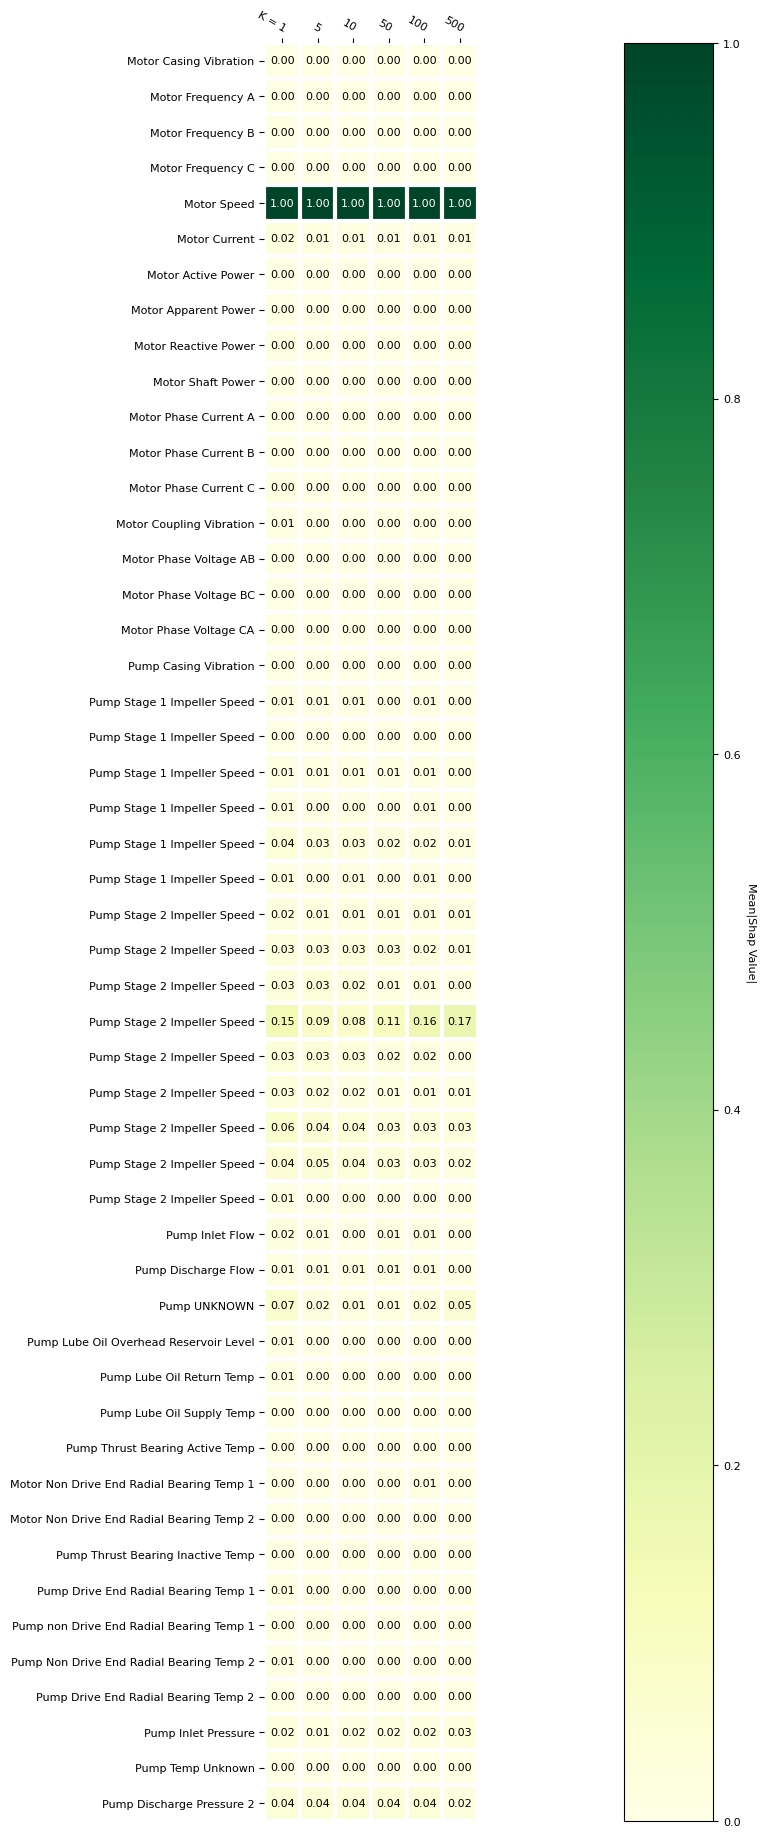

In [ ]:

# Prepare the data to do a heatmap of the normalzed SHAP values
heatmapDF = K_shaps.copy()

# Normalizar por columnas
heatmapDF = (heatmapDF - heatmapDF.min()) / (heatmapDF.max() - heatmapDF.min())


# Datos del heatmap
a = heatmapDF.to_numpy().astype(float)

# Nombre de cada una de las filas (sensores)
b = sensorProperties

# Nombre de las columnas
c = heatmapDF.columns.values.tolist()


fig, ax = plt.subplots()

im, cbar = heatmap(a, b, c, ax=ax, cmap="YlGn", cbarlabel="Mean|Shap Value|")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
fig.set_size_inches(30.5, 20.5)
plt.rcParams.update({'font.size': 8})
plt.show()

In [ ]:
# Mostramos todos los números para demostrar que los números son distintos a
# partir de 10^-2
print(K_shaps)

       K = 1         5        10        50       100       500
0   0.001324  0.001056  0.001004  0.000660  0.001241  0.000763
1   0.001066  0.000821  0.000976  0.001365  0.000855  0.000659
2   0.001473  0.000743  0.001266  0.000741  0.000419  0.000702
3   0.001077  0.001087  0.000940  0.001117  0.001050  0.000709
4   0.295260  0.322172  0.350100  0.341958  0.347945  0.374223
5   0.003526  0.004345  0.002249  0.001653  0.002637  0.001881
6   0.001381  0.001216  0.000898  0.000612  0.000953  0.001140
7   0.001408  0.001371  0.000746  0.000933  0.000537  0.000690
8   0.000998  0.000450  0.001186  0.000934  0.001389  0.000650
9   0.001447  0.001030  0.000720  0.000523  0.000512  0.000564
10  0.001819  0.000987  0.001303  0.000744  0.001178  0.001132
11  0.001770  0.000938  0.001659  0.000972  0.002041  0.000849
12  0.000859  0.000613  0.000654  0.000918  0.000960  0.000777
13  0.001378  0.001162  0.000897  0.000789  0.001056  0.000597
14  0.000884  0.001445  0.001460  0.000634  0.001392  0